# Scaling Sensitivity Analysis with Emulation

In this tutorial we demonstrate how `AutoEmulate` can facilitate finding the best emulator for the simulation of fluid flow in a cardiovascular system. 

By the end of this tutorial: 
- Participants will learn how to use `Autoemulate` for the emulation of a real-world simulation in an end-to-end pipeline. 
- Participants will learn how to explore the relationship between underlying cardiac health parameters and non-invasive measures using synthetic data, with a focus on how these insights can improve understanding and estimation of key cardiovascular dynamics


## The Problem
In the field of cardiovascular modeling, capturing the dynamics of blood flow and the associated pressures and volumes within the vascular system is crucial for understanding heart function and disease. Physics-based models that accurately represent these dynamics often require significant computational resources, making them challenging to apply in large-scale or real-time scenarios. Emulation techniques provide a way to achieve high-fidelity simulations of the cardiovascular system, allowing for efficient and accurate analysis of key hemodynamic parameters.

## Content
This tutorial includes:

1. Setting up a simulation : The system simulated is a tube with an input flow rate at any given time. The tube is divided to 10 compartments which allows for the study of the pressure and flow rate at various points in the tube. 
2. Running the simulation for 60 sets of parameters sampled from the parameter space.  
3. Using Autoemulate to find the best emulator fot this simulation 
5. Assessing model accuracy, performing sensitivity analysis.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from tqdm import tqdm
from autoemulate.compare import AutoEmulate
from sklearn.metrics import r2_score

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.flow_functions import FlowProblem

### Define your simulator

This simulator simulates a vessel divided to 10 compartments. 

##### Parameters
The simulation parameters include : 

1. R (Resistance):
Represents the resistance to blood flow in blood vessels, akin to the hydraulic resistance caused by vessel diameter and blood viscosity (Analogous to electrical resistor).
2. L (Inductance):
Represents the inertial effects of blood flow, capturing how blood resists changes in its velocity (Analogous to electrical inductor).
3. C (Capacitance):
Represents the compliance or elasticity of blood vessels, primarily large arteries, which store and release blood volume with changes in pressure (Analogous to a capacitor).


##### Boundary conditions 

1. Neumann boundary condition : Specifies the derivative of the variable at the boundary.
2. Dirichlet Boundary condition : Specifies the value of the variable directly at the boundary.

##### The setup 
The input flow rate in each compartment is $Q_i(t)$ for the $i^{th}$ compartment and the output flow rate is  $Q_{i+1}(t)$. 

$Q_0(t) = 
\begin{cases} 
A \cdot \sin^2\left(\frac{\pi}{t_d} t\right), & \text{if } 0 \leq t < T, \\
0, & \text{otherwise}.
\end{cases}$

Where:
- $Q_0(t)$  is the input pulse function (flow rate) at time  t 
- A   is the amplitude of the pulse 
- $t_d$  is the pulse duration.



In [2]:
fp = FlowProblem(ncycles=10, ncomp=10, amp=900.)
fp.generate_pulse_function()


### Solve 
Pressure in Each Compartment ($P_i$): This determines how the pressure in each compartment evolves over time, based on the inflow ($Q_i(t)$) and the outflow ($Q_{i+1}(t)$). where $i$ is the number of compartment. 




<img src="../../misc/circuit.jpg" alt="Circuit Diagram" style="width:60%;"/>

$\frac{dP_i}{dt} = \frac{1}{C_n} \left( Q_i(t) - Q_{i+1}(t) \right)$ where, $C_n = \frac{C}{n_\text{comp}}$

Flow rate equation ($Q_i$): This governs how the flow in each compartment changes over time, depending on the pressures in the neighboring compartments and the resistance and inertance properties of each compartment.

$\frac{dQ_i}{dt} = \frac{1}{L_n} \left( P_i - P_{10} - R_n Q_i(t) \right)$, where $L_n = \frac{L}{n_\text{comp}}, \quad R_n = \frac{R}{n_\text{comp}}$

In [3]:
fp.solve()

### Plotting Pressure and flow rate 

Here the pressure and flow rate have been plotted for all 10 compartments (the colour of the line fades for later compartments). As it is apaprent from the figure the peak pressure as well as the flow rate drops for the later compartments. 

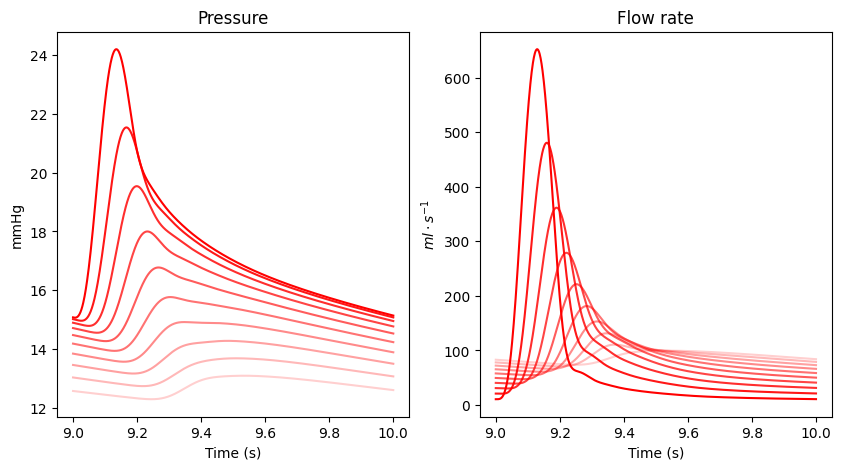

In [4]:
fig, ax = fp.plot_res()
plt.show()

### Experimental Design

We set up the parameters for the simulation and their range. The range is set to the domain of interest for the problem we are solving. Furthermore, it is important to restrict the range to enhance the fitting of the model. 



In [5]:
## specify valid parameter ranges
# Dictionary with parameters and their scaled ranges for the blood flow model
parameters_range = {
    'T': tuple(np.array([0.5, 1.5]) * 1.0),  # Cardiac cycle period (s)
    'td': tuple(np.array([0.8, 1.2]) * 0.2),  # Pulse duration (s)
    'amp': tuple(np.array([0.8, 1.2]) * 900.0),  # Amplitude (e.g., pressure or flow rate)
    'dt': tuple(np.array([0.5, 1.5]) * 0.001),  # Time step (s)
    'C': tuple(np.array([0.8, 1.2]) * 38.0),  # Compliance (unit varies based on context)
    'R': tuple(np.array([0.8, 1.2]) * 0.06),  # Resistance (unit varies based on context)
    'L': tuple(np.array([0.8, 1.2]) * 0.0017),  # Inductance (unit varies based on context)
    'R_o': tuple(np.array([0.8, 1.2]) * 0.025),  # Outflow resistance (unit varies based on context)
    'p_o': tuple(np.array([0.9, 1.1]) * 10.0)  # Initial pressure (unit varies based on context)
}

# Output the dictionary for verification

parameters_range

{'T': (0.5, 1.5),
 'td': (0.16000000000000003, 0.24),
 'amp': (720.0, 1080.0),
 'dt': (0.0005, 0.0015),
 'C': (30.400000000000002, 45.6),
 'R': (0.048, 0.072),
 'L': (0.00136, 0.0020399999999999997),
 'R_o': (0.020000000000000004, 0.03),
 'p_o': (9.0, 11.0)}

### Sampling parameters

Secondly we sample the parameter space usning the Latin hypercube sampling (LHS) method. 

Latin Hypercube Sampling (LHS) is a statistical method used for generating a sample of plausible values from a multidimensional distribution and guarantees that every sample is drawn from a different quantile of the underlying distribution. It is particularly effective for uncertainty quantification, sensitivity analysis, and simulation studies where the goal is to explore the behavior of a system or a model across a wide range of input parameter values.

In [6]:
## sample from parameter range

N_samples = 60
lhd = LatinHypercube(parameters_range.values())
sample_array = lhd.sample(N_samples)
sample_df    = pd.DataFrame(sample_array, columns=parameters_range.keys())  
print("Number of parameters", sample_df.shape[1], "Number of samples from each parameter", sample_df.shape[0])
sample_df.head()

Number of parameters 9 Number of samples from each parameter 60


,T,td,amp,dt,C,R,L,R_o,p_o
0,1.078371,0.179061,803.263624,0.000759,33.612657,0.061407,0.001965,0.020758,9.026535
1,0.530640,0.198942,844.526377,0.001375,35.830789,0.057073,0.002032,0.021821,10.850939
2,1.361265,0.164018,1017.327348,0.000555,45.188371,0.063796,0.001745,0.022860,10.471797
3,1.014375,0.187115,756.949710,0.001044,34.579278,0.067588,0.002007,0.025781,10.932655
4,1.488616,0.198242,811.629336,0.000907,35.372583,0.061190,0.001591,0.025406,10.974837


### Enforcing relationship between correlated parameters 

The parameters are randomly sampled from the parameter space. However, some of the parameters are by nature correlated. For example in our simulation the duration of the pulse $t_d$ is directly correlated with $T$ which is the length of a full cycle. In this cell, we enforce the relationship between these two parameters. In otherwords scale $t_d$ in accordance with the value of $T$.

In [7]:
# enforce parameter relations (eg td <= T)
sample_df['td'] = sample_df.apply(lambda row: row['td']* row['T'], axis=1)


### Simulate

Here we run the simulation which involves:  
1- Generating the pulse functions.  
2- Solving the differential equations.  
3- Returning the pressure and flow rate in y for every set of parameters sampled (every row of sample_df data frame).

The full output of the simulation is quite large for fitting an emulator model. Therefore, it is standard practice to grab the most relavant information for training the emulator. Here we have chosen to train the emulator on the maximum pressure in each compartment. There are a variety of outputs that could be considered (max / min / average /mean / median / gradiant / PCA ).




In [8]:
# Fixed parameters: Number of compartments and cycles
ncomp = 10
ncycles = 10

# Function to run a simulation for a given set of parameters
def simulate(param_dict):
    fp = FlowProblem(ncycles=ncycles, ncomp=ncomp, **param_dict)
    fp.generate_pulse_function()
    fp.solve()
    return fp, fp.res.t, fp.res.y

Y = []
# Iterate over each sample of parameters
for index, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
    param_dict = row.to_dict() 
    fp, t, y = simulate(param_dict) 
    # extract peak pressure
    peak_pressure = y[:ncomp, :].max()
    Y.append(peak_pressure)

100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


### Emulate & Validate

Here we setup Autoemulate. 

The models currently available for performing cross-validation are as follows: 
- sop: SecondOrderPolynomial
- rbf: RadialBasisFunctions
- rf: RandomForest
- gb: GradientBoosting
- lgbm: LightGBM
- svm: SupportVectorMachines
- gp: GaussianProcess
- gpmt: GaussianProcessMT
- gps: GaussianProcessSklearn
- nns: NeuralNetSk

We have selected four of these models for cross-validation, feel free to explore more!  

In [9]:
em = AutoEmulate()
parameter_names = list(parameters_range.keys())
em.setup(sample_df[parameter_names], Y, models = ['gp', 'svm','lgbm'])
best_model = em.compare()


,Values
Simulation input shape (X),"(60, 9)"
Simulation output shape (y),"(60,)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Scale output data (scale_output),True
Scaler output (scaler_output),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Reduce output dimensionality (reduce_dim_output),False


Cross-validating:   0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
em.summarise_cv()

,preprocessing,model,short,fold,rmse,r2
0,None,ConditionalNeuralProcess,cnp,3,4.560392,0.997178
1,None,GaussianProcess,gp,3,6.580276,0.994124
2,None,GaussianProcess,gp,2,5.840839,0.993465
3,None,GaussianProcess,gp,0,10.820508,0.991767
4,None,GaussianProcess,gp,4,7.217839,0.987873
5,None,GaussianProcess,gp,1,8.055320,0.985911
6,None,ConditionalNeuralProcess,cnp,0,25.517669,0.954214
7,None,ConditionalNeuralProcess,cnp,2,18.712580,0.932923
8,None,SupportVectorMachines,svm,3,27.525519,0.897189
9,None,ConditionalNeuralProcess,cnp,1,24.127199,0.873607


In [11]:
gp = em.get_model("GaussianProcess")
em.evaluate(gp)


,model,short,preprocessing,rmse,r2
0,GaussianProcess,gp,None,4.4152,0.9952


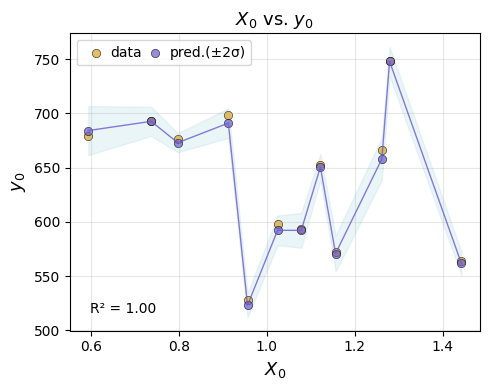

In [12]:
em.plot_eval(gp)

In [13]:
best_emulator = em.refit(gp)


### Sensitivity Analysis

1. Define the problem by creating a dictionary which contains the names and the boundaries of the parameters 
2. contribution of each parameter , importance of each parameter 
    - S₁: First-order sensitivity index.
    - S₂: Second-order sensitivity index.
    - Sₜ: Total sensitivity index.

In [14]:
# Extract parameter names and bounds from the dictionary
parameter_names = list(parameters_range.keys())
parameter_bounds = list(parameters_range.values())

# Define the problem dictionary for Sobol sensitivity analysis
problem = {
    'num_vars': len(parameter_names),
    'names': parameter_names,
    'bounds': parameter_bounds
}


In [15]:
em.sensitivity_analysis(problem=problem)


,output,parameter,index,value,confidence
0,y1,T,S1,0.003793,0.000379
1,y1,td,S1,0.024640,0.002530
2,y1,amp,S1,0.893082,0.061964
3,y1,dt,S1,0.000372,0.000059
4,y1,C,S1,0.028867,0.002382
5,y1,R,S1,0.048604,0.004261
6,y1,L,S1,0.002155,0.000243
7,y1,R_o,S1,0.000089,0.000014
8,y1,p_o,S1,0.000237,0.000029
0,y1,T,ST,0.003250,0.005674
